# Burger equation in 1D: joint estimation (vanilla inverse problem)

**In this notebook we jointly estimate the equation solution with a PINN and the equation parameter $\theta$**. To do so we append the parameter $\theta$ as an entry to the neural network and we make use of available observations. More precisely, the dynamic, boundary and initial condition losses will be the same as in the [introductory notebook](https://mia_jinns.gitlab.io/jinns/Notebooks/Tutorials/implementing_your_own_PDE_problem/) (as will still differentiated wrt $\nu$ the neural network parameters). However, we will add an observation loss that will be differentiated with respect to both the neural network parameters ($\nu$) and the equation parameter ($\theta$).

We will work with the Burger equation:
$$
\begin{cases}
\frac{\partial}{\partial t} u_\nu(t,x,\theta) + u_\nu(t,x,\theta)\frac{\partial}{\partial x}
          u_\nu(t,x,\theta) - \theta \frac{\partial^2}{\partial x^2} u_\nu(t,x,\theta) = 0,  \forall (t,x)\in I\times\Omega,\\
          u_\nu(0, x,\theta) = -\sin(\pi x), \forall x\in\partial\Omega, \text{ (initial condition)}\\
u_\nu(t,-1)=u_\nu(t,1,\theta)=0, \forall t\in I, \text{ (boundary condition)}
\end{cases}
$$
We choose the time interval $I=[0,1]$ and the domain $\Omega=[-1,1]$. We denote by $\partial\Omega$ the boundary domain.

Therefore, we aim at solving:

$$
\hat{\nu},\hat{\theta}=\text{argmin}_{\nu,\theta} \mathcal{L}(\nu,\theta)
$$
with the loss:

$$
\begin{align*}
\mathcal{L}(\nu,\theta)&=\sum_{i}^{n_x}\sum_j^{n_t}\Big(u_\nu(t_j,x_i,\theta) + u_\nu(t_j,x_i,\theta)\frac{\partial}{\partial x}
          u_\nu(t_j,x_i,\theta) - \theta \frac{\partial^2}{\partial x^2} u_\nu(t_j,x_i,\theta)\Big)^2\\
&+w_{ic}\sum_i^{nx}\Big(u_\nu(0,x_i,\theta)-(-\sin(\pi x_i))\Big)^2\\
&+w_{bc}\sum_j^{n_t}\Big[\Big(u_\nu(t_j,-1)\Big)^2+\Big(u_\nu(t_j,1)\Big)^2\Big]
\end{align*}
$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


## Imports

In [2]:
import jinns

Import other dependencies

In [3]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"
import jax
import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt
from functools import partial
import jinns

In [4]:
key = jax.random.PRNGKey(42)

2024-10-15 11:15:17.557623: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.3.107. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Define the equation parameters

In [5]:
# True is : theta = 1 / (100 * jnp.pi)
key, subkey = jax.random.split(key)
theta_ori = jnp.array([1 / (100 * jnp.pi)])
print(f"{theta_ori=}")
theta = theta_ori + jax.random.normal(subkey, shape=(1,)) * 0.01
print(f"{theta=}")

theta_ori=Array([0.0031831], dtype=float32)
theta=Array([0.01687779], dtype=float32)


## Observations

We use artificial observations from the estimated solution from the other notebook on Burger equation.

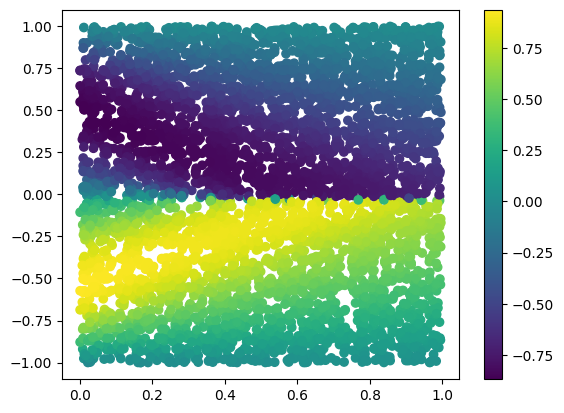

In [6]:
observations = jnp.load("burger_solution_grid.npy")
key, subkey = jax.random.split(key)
size_subsample = 5000
time_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[0], 1),
    shape=(size_subsample,),
    replace=True # we do not have enough observations
)
key, subkey = jax.random.split(key)
size_subsample = 5000
omega_subsample = jax.random.choice(
    subkey,
    jnp.arange(0, observations.shape[1], 1),
    shape=(size_subsample,),
    replace=True # we do not have enough observations
)
obs_batch = observations[
    time_subsample,
    omega_subsample
]

plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()


__Optionally blur the observed values__

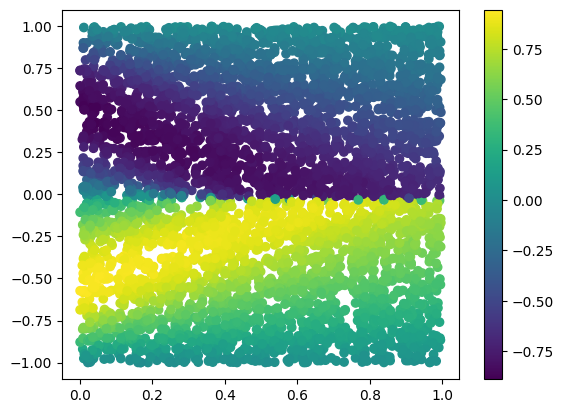

In [7]:
obs_batch_ori = obs_batch.copy()
key, subkey = jax.random.split(key)
obs_batch = obs_batch.at[:, 2].set(
    obs_batch[:, 2] +
    jax.random.normal(subkey, obs_batch[:, 2].shape) * 0.01
)


plt.scatter(obs_batch[:, 0], obs_batch[:, 1], c=obs_batch[:, 2])
plt.colorbar()
plt.show()


## Estimate the solution to the Burger equation as well as the viscosity coefficient

*Define the domain and the associated data generator*

In [8]:
n = 500
nt = 500
nb = 2
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 1
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
Tmax = 1
method = "uniform"

train_data = jinns.data.CubicMeshPDENonStatio(
    key=subkey,
    n=n,
    nb=nb,
    nt=nt,
    omega_batch_size=omega_batch_size,
    omega_border_batch_size=omega_border_batch_size,
    temporal_batch_size=temporal_batch_size,
    dim=dim,
    min_pts=(xmin,),
    max_pts=(xmax,),
    tmin=tmin,
    tmax=tmax,
    method=method
)


*Define the data generator for the observations*

In [9]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    subkey,
    omega_batch_size * temporal_batch_size,
    observed_pinn_in=obs_batch[:, :2],
    observed_values=obs_batch[:, 2:3]
)

*Define the PINN*

Create the neural network architecture for the PINN with `equinox`. **Note that we want the entry of the PINN to be composed of 3 elements: `t`, `x` and `theta` (the Burger equation's parameter).** To do so, we create an input transform function for the PINN that plays the role of concatenating the `theta` to `t` and `x`. We know from reading the documentation that an `input_transform` has 2 parameters:

- `t_x`, i.e., `t` and `x` concatenated in the case of non-stationary equations,
- `params` the main dictionary of parameters (that we will define below in this notebook),

from that, we can define an PINN entry that accepts the some other parameters of the model.

In [10]:
eqx_list = (
    (eqx.nn.Linear, 3, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 50),
    (jax.nn.tanh,),
    (eqx.nn.Linear, 50, 1)
)
def input_transform(t_x, params):
    t_x_params = jnp.concatenate([t_x, params.eq_params["theta"]], axis=-1)
    return t_x_params
key, subkey = jax.random.split(key)
u = jinns.utils.create_PINN(subkey, eqx_list, "nonstatio_PDE", 1, input_transform=input_transform)
init_nn_params = u.init_params()

*Define the jinns parameter object*

In [11]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "theta":theta,
    }
)

*Define the loss weights*

In [12]:
loss_weights = jinns.loss.LossWeightsPDENonStatio(
    dyn_loss=1.,
    initial_condition=1.,
    boundary_loss=1.,
    observations=10.,
)

*Define the initial condition*

Text(0.5, 1.0, 'Init condition $u_0$')

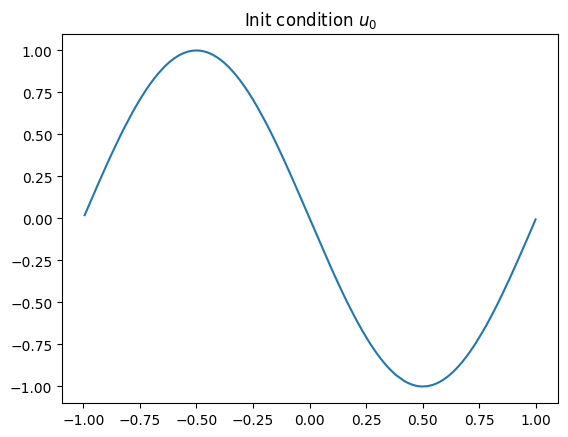

In [13]:
def u0(x):
    return -jnp.sin(jnp.pi * x)

plt.plot(train_data.omega.sort(axis=0), jax.vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")


*Define the dynamic loss term*

In [34]:
from jinns.loss import PDENonStatio

from jaxtyping import Float, Array

import jinns.parameters

class BurgerEquation(PDENonStatio):
    r"""
    Return the Burger dynamic loss term (in 1 space dimension):

    $$
        \frac{\partial}{\partial t} u(t,x) + u(t,x)\frac{\partial}{\partial x}
        u(t,x) - \theta \frac{\partial^2}{\partial x^2} u(t,x) = 0
    $$
    """

    def equation(
        self,
        t: Float[Array, "1"],
        x: Float[Array, "dim"],
        u: eqx.Module,
        params: jinns.parameters.Params,
    ) -> Float[Array, "1"]:
        r"""
        Evaluate the dynamic loss at :math:`(t,x)`.

        Parameters
        ---------
        t
            A time point
        x
            A point in $\Omega$
        u
            The PINN
        params
            The dictionary of parameters of the model.
        """
        # Note that the last dim of u is nec. 1
        u_ = lambda t, x: jnp.squeeze(u(t, x, params)[u.slice_solution])
        du_dt = jax.grad(u_, 0)
        du_dx = jax.grad(u_, 1)
        d2u_dx2 = jax.grad(
            lambda t, x: du_dx(t, x)[0],
            1,
        )

        return du_dt(t, x) + self.Tmax * (
            u(t, x, params) * du_dx(t, x) - params.eq_params["theta"] * d2u_dx2(t, x)
        )


be_loss = BurgerEquation(Tmax=1)

*Define how to differentiate each term of the loss* Note that the main params of the problem must be passed since we use the `from_str()` constructor

In [35]:
derivative_keys = jinns.parameters.DerivativeKeysPDENonStatio.from_str(
    dyn_loss="nn_params",
    boundary_loss="nn_params",
    initial_condition="nn_params",
    observations=jinns.parameters.Params(
        nn_params = True,
        eq_params = {
            'theta':True,
        }
    ),
    params=init_params
)

*Define the PDE PINN loss*

In [36]:
loss = jinns.loss.LossPDENonStatio(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=be_loss,
    derivative_keys=derivative_keys,
    omega_boundary_fun=lambda t, dx: 0,
    omega_boundary_condition="dirichlet",
    initial_condition_fun=u0,
)

*Define the optimizer and set-up the optimization*

In [37]:
params = init_params
tx = optax.adam(learning_rate=1e-3)
key, subkey = jax.random.split(key, 2)
n_iter = 10000


*Define which parameters to track: $\theta$*

In [38]:
tracked_params = jinns.parameters.Params(
    eq_params={"theta":True}
)

*Run the optimization*

In [39]:
params, total_loss_list, loss_by_term_dict, _, _, _, stored_params, _, _ = jinns.solve(
    init_params=params,
    data=train_data,
    optimizer=tx,
    loss=loss,
    n_iter=n_iter,
    tracked_params=tracked_params,
    obs_data=obs_data,
    print_loss_every=10000
)

[train] Iteration 0: loss value = 3.8620011806488037
Stopping main optimization loop, cause: max iteration is reached
Final iteration 10000: train loss value = 0.4891240894794464


## Results

Plot the tracked parameters

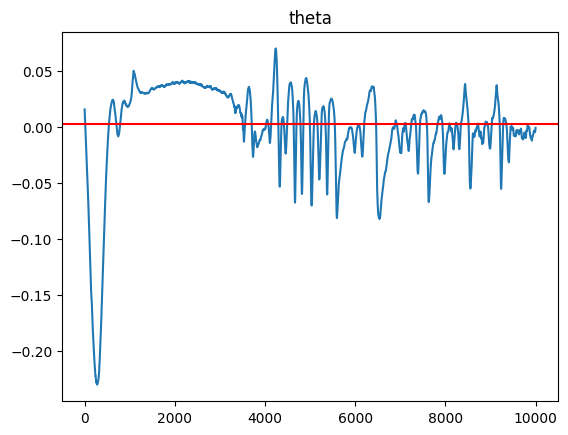

In [40]:
colors = ['blue']
plt.plot(stored_params.eq_params["theta"])
plt.axhline(y=theta_ori, color='r', linestyle='-')
plt.title(f"theta")
plt.show()


Plot the loss values

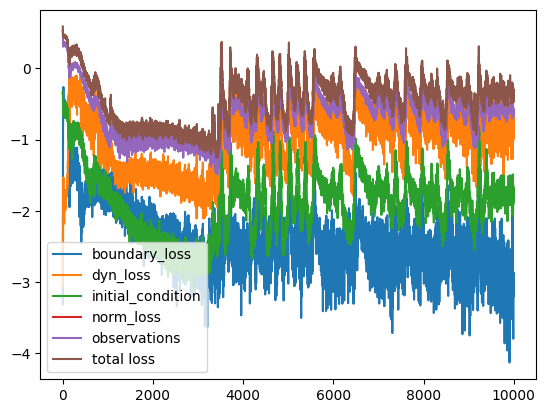

In [41]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();


Plot the PDE solutions learned by the PINN

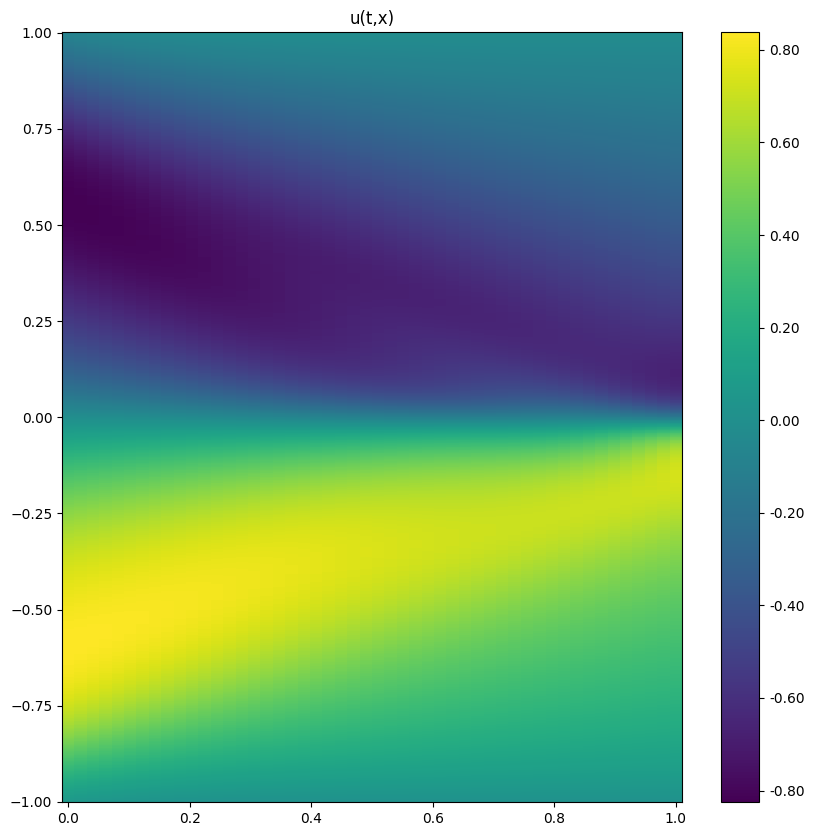

In [42]:
u_est = lambda t, x: u(t, x, params)
nx = 1000
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 50
val_times = jnp.linspace(tmin, tmax, ntime)
jinns.plot.plot1d_image(u_est, xdata=val_xdata, times=val_times, cmap="viridis", colorbar=True, figsize=(10,10), title="u(t,x)")


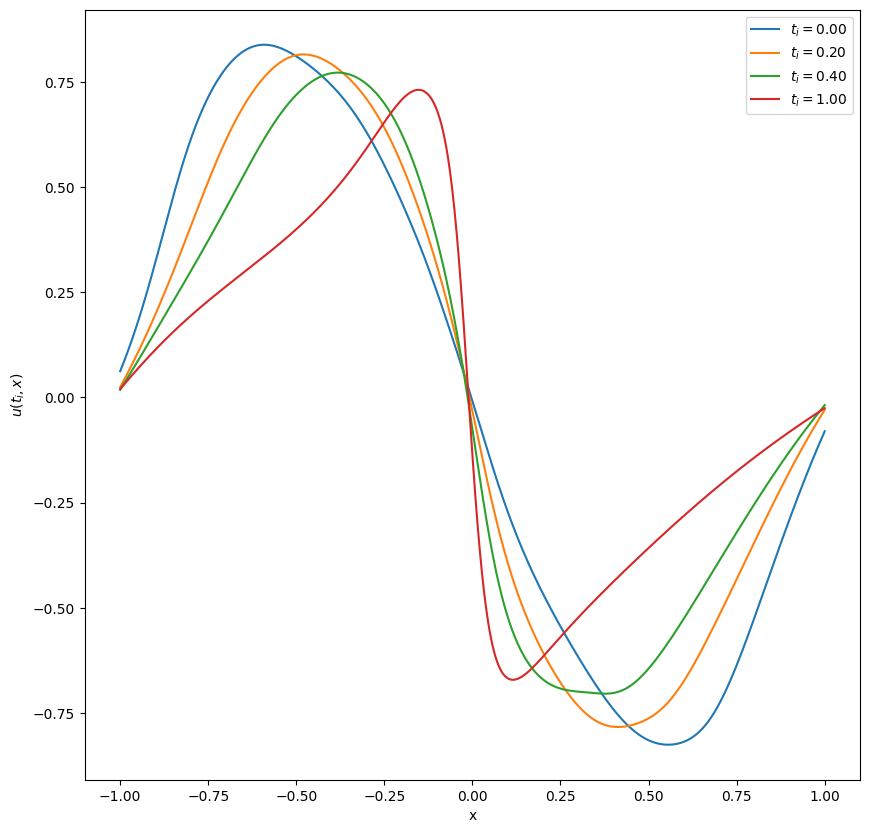

In [43]:
time_slices = [0, 0.2, 0.4, 1]
jinns.plot.plot1d_slice(u_est, xdata=val_xdata, time_slices=time_slices)